<h1> Financial Econometrics II – Master 203 - Projects - Trend Following Strategy <h1>

<h2> Data Preparation and Preliminary Analysis <h2>

**Import libraries and data**

In [40]:
import Kalman_trend as k
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from scipy.stats import skew, kurtosis, jarque_bera
import statsmodels.api as sm
from sklearn.linear_model import Lasso
from sklearn import preprocessing

**Data Loading**

In [26]:
data_SP500=pd.read_excel('GROUP DATASET.xlsx', 'Feuil2',usecols='A:B',index_col=0)
data_SP500= data_SP500.iloc[1:]
data_SP500

,S&P500 net total return index
"Data source: Bloomberg, Orion Financial Partners",
1999-01-04,1668.52
1999-01-05,1691.23
1999-01-06,1728.94
1999-01-07,1725.47
1999-01-08,1732.75
...,...
2025-11-24,12835.97
2025-11-25,12952.86
2025-11-26,13042.48


Data Processing for Kalman filter

In [6]:
dates=pd.to_datetime(data_SP500.index)
daily_prices_SP500=np.array(data_SP500) # We transform the pandas dataframe in to an array for Kalman Filter

**Local Linear Trend**

In [7]:
# The Kalman filter needs : Yt, Xt and Ut as entries.
# We know that for each step, as we use the trend following model, we have Xt=(1 0)

c=np.ones((len(daily_prices_SP500),1))
z=np.zeros((len(daily_prices_SP500),1))
xt=np.concatenate((c,z),axis=1)

# We don't have any control variables so that we put u=0
yt = np.log(daily_prices_SP500.astype(float).flatten())
output=k.Kalman(yt,xt,0)

Optimization terminated successfully.
         Current function value: -2.759564
         Iterations: 12
         Function evaluations: 120
         Gradient evaluations: 20


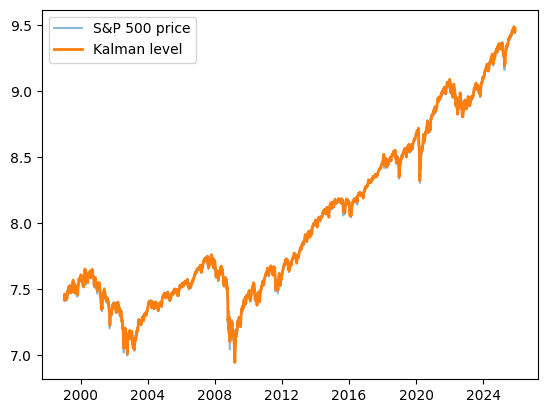

In [8]:
T_t = output[0][:, 0]   # niveau latent
plt.plot(dates,yt, label="S&P 500 price", alpha=0.5)
plt.plot(dates,T_t, label="Kalman level", linewidth=2)
plt.legend()

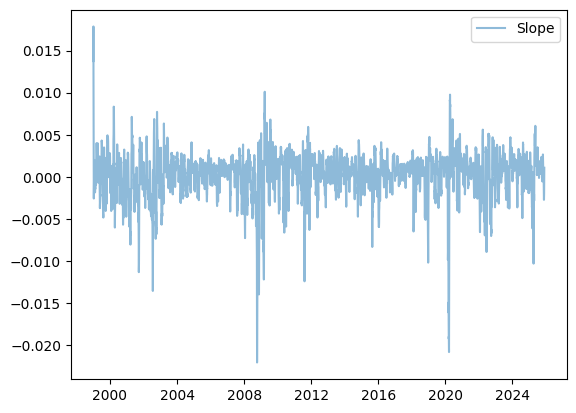

In [9]:
S_t = output[0][:, 1]
# Note: The first value can be an outlier due to the initialization of the filter, so we look only after 1:
# => C'est curieux la première valeur est 0.4 ...
plt.plot(dates[1:],S_t[1:], label="Slope", alpha=0.5)
plt.legend()

# Q1) From what level of the spread Δₜ could we consider that the difference between the S&P500 index and its trend is “abnormal” ?

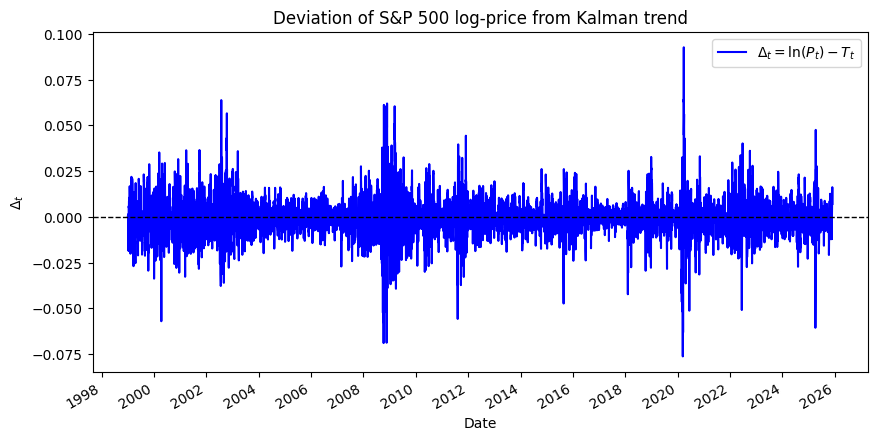

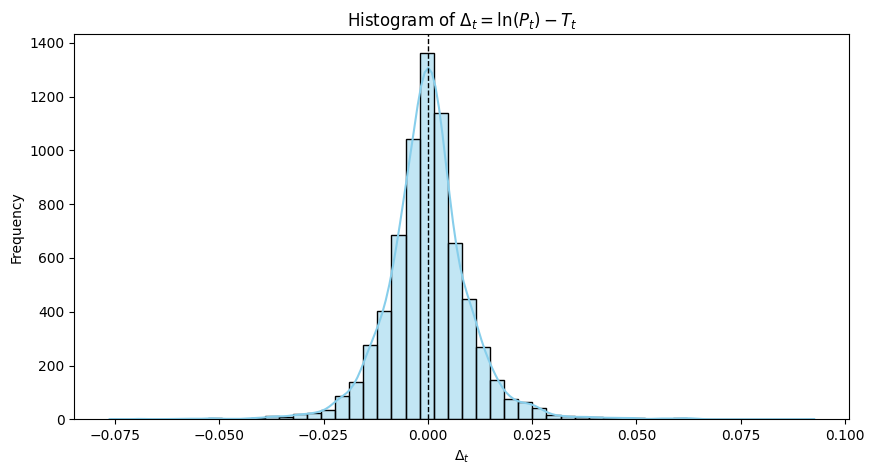

In [18]:
# Δ_t = ln(P_t) - T_t
Delta = yt - T_t

# Tracé
plt.figure(figsize=(10,5))
plt.plot(dates, Delta, label=r'$\Delta_t = \ln(P_t) - T_t$', color='blue')

# ligne zéro pour référence
plt.axhline(0, color='black', linewidth=1, linestyle='--')

# formatage des dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=2))
plt.gcf().autofmt_xdate()

plt.title("Deviation of S&P 500 log-price from Kalman trend")
plt.xlabel("Date")
plt.ylabel(r"$\Delta_t$")
plt.legend()
plt.show()

# Histogramme avec KDE
plt.figure(figsize=(10,5))
sns.histplot(Delta, bins=50, kde=True, color='skyblue')

# ligne zéro pour référence
plt.axvline(0, color='black', linewidth=1, linestyle='--')

plt.title(r"Histogram of $\Delta_t = \ln(P_t) - T_t$")
plt.xlabel(r"$\Delta_t$")
plt.ylabel("Frequency")
plt.show()

In [20]:
# Statistiques classiques
mean_delta = np.mean(Delta)
var_delta  = np.var(Delta, ddof=1)      # variance échantillon
skew_delta = skew(Delta)
kurt_delta = kurtosis(Delta, fisher=False)  # Fisher=False => 3 pour normale

# Jarque-Bera statistic (valeur brute)
JB_stat, _ = jarque_bera(Delta)

# Valeurs attendues pour une normale
mean_normal = 0
var_normal  = 1
skew_normal = 0
kurt_normal = 3
JB_normal  = 0  # Jarque-Bera = 0 pour une normale parfaite

# Résumé pandas pour affichage propre
summary = pd.DataFrame({
    'Statistic': ['Mean', 'Variance', 'Skewness', 'Kurtosis', 'JB_stat'],
    'Delta_t': [mean_delta, var_delta, skew_delta, kurt_delta, JB_stat],
    'Normal expected': [mean_normal, var_normal, skew_normal, kurt_normal, JB_normal]
})

print(summary)

  Statistic       Delta_t  Normal expected
0      Mean     -0.000003                0
1  Variance      0.000108                1
2  Skewness      0.211111                0
3  Kurtosis      9.212747                3
4   JB_stat  11342.126220                0


In [25]:
#  Calcul des quantiles
q_low, q_high = np.quantile(Delta, [0.05, 0.95])
print(f"5%-quantile (lower bound) : {q_low:.6f}")
print(f"95%-quantile (upper bound): {q_high:.6f}\n")

#  Extraction des cas “anormaux”
abnormal = Delta[(Delta < q_low) | (Delta > q_high)]

# Affichage des valeurs anormales
print(f"Number of 'abnormal' points: {len(abnormal)}")
print("Some examples of abnormal Δ_t values:")
print(pd.Series(abnormal))


5%-quantile (lower bound) : -0.015367
95%-quantile (upper bound): 0.015827

Number of 'abnormal' points: 702
Some examples of abnormal Δ_t values:
0     -0.018571
1     -0.018349
2      0.016708
3     -0.020156
4      0.021859
         ...   
697   -0.018149
698   -0.015777
699   -0.020855
700    0.015939
701    0.016181
Length: 702, dtype: float64




The variable : 

$$
\Delta_t = \ln(P_t) - T_t
$$

measures the deviation of the observed log-price $P_t$ from its latent Kalman trend $T_t$.  

We have shown that the distribution of $\Delta_t$ is **clearly non-Gaussian**, with heavy tails and skewness, and the Jarque-Bera test strongly rejects normality. Therefore, standard deviation-based thresholds are unreliable.  

Abnormal deviations are defined using **empirical quantiles**, for example:  

$$
\Delta_t < Q_{0.05} \quad \text{or} \quad \Delta_t > Q_{0.95}
$$

where $Q_{0.05}$ and $Q_{0.95}$ are the 5%- and 95%-quantiles of the $\Delta_t$ distribution, capturing extreme movements or atypical market episodes.


# Q2)  Are some of the macro factors provided good explanatory factors of the level spread level?

# Variance Inflation Factor (VIF) Analysis

Before running regressions of the spread $\Delta_t$ on macroeconomic factors, we check for **multicollinearity** among the explanatory variables using the Variance Inflation Factor (VIF).  

- Each factor is regressed on all other factors, and the VIF is calculated as:  

$$
\text{VIF}_i = \frac{1}{1 - R_i^2}
$$

where $R_i^2$ is the coefficient of determination of the regression of factor $i$ on the remaining factors.  

- **Interpretation:**  
  - VIF ≈ 1 → little or no collinearity  
  - VIF > 5 (or 10) → high collinearity; factor may need to be removed or combined  

By computing VIF, we identify and potentially exclude highly collinear macro factors, ensuring that our regression coefficients for $\Delta_t$ are stable and interpretable.  



In [36]:
data_macro = pd.read_excel(
    'GROUP DATASET.xlsx',
    sheet_name='Feuil2',    # nom de la feuille
    usecols='A:M',          # colonnes SP500 + macro factors
    index_col=0             # première colonne comme index (SP500 ou date)
)

# Supprimer la première ligne de description si nécessaire
data_macro = data_macro.iloc[1:]
data_macro.drop(columns=['S&P500 net total return index'], inplace=True)

# Afficher un aperçu
data_macro


,TED Spread (USA),Equity implied volatility (USA),High yield spread (USA),Global liquidity risk index,Global market risk index,Global credit risk index,Global FX risk index,Macro cycle (USA),Macro cycle (DVP),Macro cycle USA (3 months variation),Macro cycle - dvp (3 month variation)
"Data source: Bloomberg, Orion Financial Partners",,,,,,,,,,,
1999-01-04,0.58831,26.17,563,-0.425038,0.092936,1.242224,0.788118,0.722628,0.252417,0.016776,-0.013004
1999-01-05,0.57431,24.46,557,0.584583,0.275358,1.152422,0.609058,0.722628,0.251733,0.016776,-0.012592
1999-01-06,0.60631,23.34,556,0.570934,-0.088812,1.193793,0.439895,0.743839,0.259383,0.04202,-0.00641
1999-01-07,0.6245,24.37,553,0.484931,0.406243,1.172206,0.367209,0.747058,0.261614,0.017492,-0.010196
1999-01-08,0.56481,23.28,541,0.404513,0.277222,1.127302,0.360412,0.752244,0.257027,0.022678,-0.014355
...,...,...,...,...,...,...,...,...,...,...,...
2025-11-24,0.2167,20.52,315,0.305404,0.42344,-0.384636,-1.101898,-0.091522,-0.012186,-0.044593,-0.028214
2025-11-25,0.246,18.56,310,0.687865,0.088921,-0.423929,-1.189613,-0.123568,-0.030158,-0.085032,-0.049454
2025-11-26,0.1394,17.19,300,-0.091968,-0.20084,-0.561976,-1.256451,-0.135555,-0.036109,-0.102204,-0.055511


In [38]:
# Assurons-nous que toutes les colonnes sont float
data_macro = data_macro.astype(float)

# Initialiser le VIF array
VIF = np.zeros(data_macro.shape[1])

# Boucle sur chaque facteur
for i in range(data_macro.shape[1]):
    # Régress le facteur i sur tous les autres
    model = sm.OLS(data_macro.iloc[:, i], sm.add_constant(data_macro.drop(data_macro.columns[i], axis=1)))
    results = model.fit()
    VIF[i] = 1 / (1 - results.rsquared)

# Tableau clair avec noms de facteurs et VIF
table_VIF = pd.DataFrame({
    "Factor": data_macro.columns,
    "VIF": np.round(VIF, 2)
})

table_VIF


,Factor,VIF
0,TED Spread (USA),1.97
1,Equity implied volatility (USA),4.79
2,High yield spread (USA),4.35
3,Global liquidity risk index,1.85
4,Global market risk index,2.42
5,Global credit risk index,2.61
6,Global FX risk index,2.00
7,Macro cycle (USA),17.36
8,Macro cycle (DVP),17.41
9,Macro cycle USA (3 months variation),15.70


**Results interpretation:**  

- **Low to moderate collinearity (VIF ≈ 1–5):**  
  TED Spread, Equity implied volatility, High yield spread, Global liquidity risk index, Global market risk index, Global credit risk index, Global FX risk index.  
  These factors are suitable for inclusion in the regression.

- **High collinearity (VIF > 10):**  
  Macro cycle (USA), Macro cycle (DVP), Macro cycle USA (3 months variation), Macro cycle - DVP (3 months variation).  
  These factors are strongly correlated with each other. It is recommended to **select one or combine them** to avoid unstable regression coefficients.


# LASSO Regression Approach

To explain the spread $\Delta_t$ using macroeconomic factors, we opt for a **LASSO regression** rather than Ridge regression.  

- Unlike Ridge, LASSO can **shrink some coefficients exactly to zero**, providing automatic **variable selection**.  
- This is particularly useful given the **high collinearity** among some macro factors (e.g., the macro cycle variables with high VIF).  
- LASSO helps produce a **parsimonious and interpretable model**, retaining only the most relevant explanatory variables.  

The next step is to visualize the **regularization path**, plotting each coefficient as a function of the penalization parameter $\lambda$. Unlike in the course, we fully standardize both the macro factors and the spread level before applying LASSO. This ensures that the penalization affects all coefficients comparably, regardless of the original scale of the variables, and allows for a meaningful comparison of factor importance.


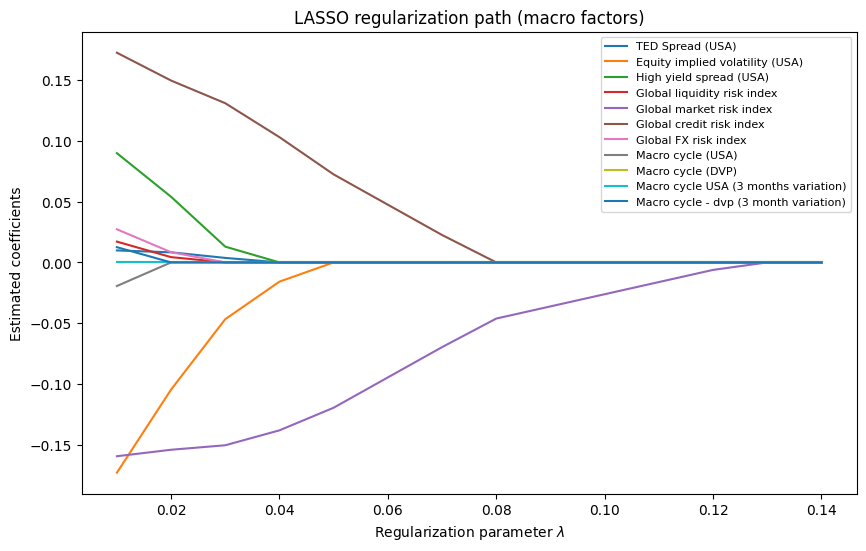

In [49]:
# ===============================
# Data
# ===============================

# Explanatory variables (macros)
X = np.array(data_macro)
FACTOR_NAMES = data_macro.columns

# Dependent variable: spread level Δ_t
Y = np.array(Delta).reshape(-1, 1)

# Standardization (as in the course)
X = preprocessing.scale(X, with_mean=True)
Y = preprocessing.scale(Y, with_mean=True)

# ===============================
# LASSO path
# ===============================

lambda_range = np.arange(0.01, 0.15, 0.01)
lasso_path = np.zeros((lambda_range.shape[0], X.shape[1]))

for j, lam in enumerate(lambda_range):
    model = Lasso(alpha=lam, fit_intercept=True, max_iter=10000)
    model.fit(X, Y.ravel())
    lasso_path[j, :] = model.coef_

# ===============================
# Plot coefficient paths
# ===============================
plt.figure(figsize=(10,6))

for i, name in enumerate(data_macro.columns):
    plt.plot(lambda_range, lasso_path[:, i], label=name)

plt.xlabel(r"Regularization parameter $\lambda$")
plt.ylabel("Estimated coefficients")
plt.title("LASSO regularization path (macro factors)")
plt.legend(loc='best', fontsize=8)
plt.show()



The regularization parameter $\lambda$ is selected using **cross-validation**, in order to minimize the out-of-sample mean squared prediction error.  
Given the size of the dataset, we rely on **10-fold cross-validation**, which provides a well-established compromise between bias and variance in the estimation of prediction errors. This approach ensures a robust and stable selection of $\lambda$, while limiting the sensitivity of the results to sampling variability.


In [47]:
from sklearn.linear_model import LassoCV
from sklearn import preprocessing
import numpy as np
import pandas as pd

# ----------------------------
# Data preparation
# ----------------------------
X = np.array(data_macro)        # macro factors
Y = np.array(Delta)             # spread level Δ_t

# Standardization (crucial for LASSO)
X = preprocessing.scale(X, with_mean=True)
Y = preprocessing.scale(Y, with_mean=True)

# ----------------------------
# Lambda grid
# ----------------------------
lambda_range = np.arange(1e-4, 1, 1e-3)

# ----------------------------
# LASSO with 10-fold cross-validation only
# ----------------------------
model_lasso = LassoCV(
    alphas=lambda_range,
    fit_intercept=True,
    cv=10,
    max_iter=10000
)

model_lasso.fit(X, Y)

# ----------------------------
# Output DataFrame
# ----------------------------
lasso_summary = pd.DataFrame(
    model_lasso.coef_,
    index=data_macro.columns,
    columns=["LASSO coefficient (10-fold CV)"]
)

# Add sum of betas
lasso_summary.loc["sum_beta"] = lasso_summary.sum()
# Add sum of absolute betas
lasso_summary.loc["sum_abs_beta"] = lasso_summary.abs().sum()

# Display optimal lambda and the table
print("Optimal lambda (10-fold CV):", model_lasso.alpha_)
lasso_summary


Optimal lambda (10-fold CV): 0.0131


,LASSO coefficient (10-fold CV)
TED Spread (USA),0.008744
Equity implied volatility (USA),-0.150132
High yield spread (USA),0.080067
Global liquidity risk index,0.012821
Global market risk index,-0.157964
Global credit risk index,0.163073
Global FX risk index,0.021620
Macro cycle (USA),-0.009763
Macro cycle (DVP),-0.000000
Macro cycle USA (3 months variation),0.000000


### Note

Looking at the LASSO coefficients around the optimal λ (10-fold CV), we notice that the **macro cycle factors** receive very small coefficients:

- `Macro cycle (USA)` ≈ -0.0098  
- `Macro cycle (DVP)` ≈ 0  
- `Macro cycle USA (3 months variation)` ≈ 0  
- `Macro cycle - dvp (3 month variation)` ≈ 0.0043  

These results are consistent with the **high VIF values** we observed previously for these factors (VIF > 15), indicating strong **multicollinearity**.  
LASSO automatically shrinks the coefficients of highly collinear variables, often to zero, to prevent instability in the regression.  
Hence, these macro cycle variables contribute little to the predictive model of Δ_t once penalization is applied, while other factors with lower VIF maintain larger coefficients and are considered more informative.


# Q2)  Are some of the macro factors provided good explanatory factors of the level spread level?